In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

from collections import defaultdict
import PIL
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson
from itertools import chain
from scipy.special import i0




from tqdm import tqdm
import scipy.cluster.hierarchy as hcluster
from scipy import ndimage
# change the following to %matplotlib notebook for interactive plotting
%matplotlib notebook
from scipy.signal import find_peaks
# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import cv2
import pims
import trackpy as tp

## import images


def minimum_close_values(lst, threshold):
    result = []
    current_group = [lst[0]]
    
    for i in range(1, len(lst)):
        if lst[i] - lst[i-1] <= threshold:
            current_group.append(lst[i])
        else:
            minimum = min(current_group)
            result.append(minimum)
            current_group = [lst[i]]
    
    minimum = min(current_group)
    result.append(minimum)
    
    return result


def filter_elements(A, B, threshold):
    filtered_list = []
    for element_A in A:
        for element_B in B:
            if abs(element_A - element_B) <= threshold:
                filtered_list.append(element_A)
                break  # Break out of the inner loop once a match is found
    return filtered_list
def count_ones(matrix):
    count = 0
    tot=0
    for row in matrix:
        for element in row:
            tot+=1
            if element == 1:
                count += 1
    return (count/tot)*100



def subtract_with_previous(lst):
    result = []
    for i in range(1, len(lst)):
        diff = np.abs(lst[i] - lst[i - 1])
        result.append(diff)
    return result

def find_deviation(file):
    @pims.pipeline
    def gray(image):
        return image[:, :, 1]  # Take just the green channel

    frames = pims.open(file)
    first_frame = frames[1]
    blurred_frame = cv2.GaussianBlur(first_frame, (5, 5),100)  # Applying Gaussian blur with kernel size (5, 5)
    threshold = 20  # Set desired threshold value

    binary_img = np.where(blurred_frame > threshold, 1,0)
    
  
    Area_initial = count_ones(binary_img)
    center_of_mass_initial = ndimage.measurements.center_of_mass(binary_img)
    Area_store=[]
    av_vec_store=[]
    r_cm_store=[]
    var_vector_store=[]
    cm_coordinates_x=[]
    cm_coordinates_y=[]
    for n in range(0,100):
        first_frame = frames[n]
        blurred_frame = cv2.GaussianBlur(first_frame, (5, 5),100)  # Applying Gaussian blur with kernel size (5, 5)
        threshold = 20  # Set desired threshold value

        binary_img = np.where(blurred_frame > threshold, 1,0)
        Area = count_ones(binary_img)
        Area_store.append(Area)
        
        %matplotlib notebook
        # Load the binary image
        image = binary_img
        image = cv2.convertScaleAbs(image)
        center_of_mass = ndimage.measurements.center_of_mass(binary_img)
        
        cm_coordinates_x.append(center_of_mass[0])
        cm_coordinates_y.append(center_of_mass[1])
        r_cm_store.append(np.sqrt(center_of_mass[0]**2+center_of_mass[1]**2))
        
        # Apply Canny edge detection
        edges = cv2.Canny(image, 0, 1)  # Adjust the thresholds as needed
       
        # Convert edge image to binary format
        edges = edges.astype(np.uint8)

        # Find contours of the edges
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Combine all edge coordinates into a single list
        edge_coordinates = []
        for contour in contours:
            contour_coordinates = []
            for point in contour:
                x, y = point[0]
                contour_coordinates.append((x, y))
            edge_coordinates.extend(contour_coordinates)

        # Convert edge_coordinates to a NumPy array
        edge_coordinates = np.array(edge_coordinates)
        coordinates = edge_coordinates
        coordinates = np.array(coordinates)

        # Calculate radial distance from the origin
        distances=[]
        for pos in edge_coordinates:
            r=np.sqrt((pos[0]-center_of_mass_initial[0])**2+(pos[1]-center_of_mass_initial[1])**2)
            distances.append(r)
        av_dist_time=np.mean(distances)
        
        # Print the radial distances
        #print(np.mean(distances))
        av_vec_store.append(np.mean(distances))
        var_time=[]
        for r in distances:
            var_time.append(np.abs(r-av_dist_time))
        
        var_vector_store.append(np.mean(var_time))
    
    difference = subtract_with_previous(av_vec_store)
    area_change= subtract_with_previous(Area_store)
    
    variance_change=subtract_with_previous(var_vector_store)
    cm_coord_change_x=subtract_with_previous(cm_coordinates_x)
    cm_coord_change_y=subtract_with_previous(cm_coordinates_y)
    ##r_cm_change= subtract_with_previous(r_cm_store)
    r_cm_change= [i**2+j**2 for i,j in zip(cm_coord_change_x,cm_coord_change_x)]
    Area_initial=1
    normalised_difference=[i/Area_initial for i in difference ]
    normalised_area_change=[i/Area_initial for i in  area_change]
    normalised_r_cm_change=[i/Area_initial for i in  r_cm_change]
    normalised_variance_change=[i/Area_initial for i in  variance_change]
    
    return normalised_difference,normalised_area_change,normalised_r_cm_change,normalised_variance_change

def boundary_tracking(file):
    m_p=1
    Fps=1
    @pims.pipeline
    def gray(image):
        return image[:, :, 1]  # Take just the green channel

    frames = pims.open(file)
    first_frame = frames[0]

    blurred_frame = cv2.GaussianBlur(first_frame, (5, 5),100)  # Applying Gaussian blur with kernel size (5, 5)
    threshold = 20  # Set desired threshold value

    binary_img = np.where(blurred_frame > threshold, 1,0)

    #center_of_mass = ndimage.measurements.center_of_mass(binary_img)
    surface_store=[]
    rmin_frame=[]
    angle_max=[]
    time=[]
    
    for n in range(0,len(frames)):
        time.append(n)
        first_frame = frames[n]
        blurred_frame = cv2.GaussianBlur(first_frame, (5, 5),100)  # Applying Gaussian blur with kernel size (5, 5)
        threshold = 20  # Set desired threshold value

        binary_img = np.where(blurred_frame > threshold, 1,0)
        center_of_mass = ndimage.measurements.center_of_mass(binary_img)
        
        %matplotlib notebook
        # Load the binary image
        image = binary_img
        image = cv2.convertScaleAbs(image)
        
        
        
        # Apply Canny edge detection
        edges = cv2.Canny(image, 0, 1)  # Adjust the thresholds as needed
        
        # Convert edge image to binary format
        edges = edges.astype(np.uint8)
    
        # Find contours of the edges
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Combine all edge coordinates into a single list
        edge_coordinates = []
        for contour in contours:
            contour_coordinates = []
            for point in contour:
                x, y = point[0]
                contour_coordinates.append((x, y))
            edge_coordinates.extend(contour_coordinates)

        # Convert edge_coordinates to a NumPy array
        edge_coordinates = np.array(edge_coordinates)
        angle_to_fix=np.linspace(0,360,25)
        edge_coordinates_fixed=[]
        angle=[]
        r_time=[]
        
        for pos in edge_coordinates:
            x, y = pos
            rmin_frame.append(np.sqrt((x-center_of_mass[1])**2+(y-center_of_mass[0])**2))
            r_time.append(np.sqrt((x-center_of_mass[1])**2+(y-center_of_mass[0])**2))
            
            theta=abs(np.arctan((y-center_of_mass[0])/(x-center_of_mass[1]))*57.2958)
            dx=(x-center_of_mass[1])
            dy=(y-center_of_mass[0])
        
            if dx>0 and dy>0:
                new_angle=theta
                angle.append(new_angle)
            if dx<0 and dy>0:
                new_angle=180-theta
                angle.append(new_angle)
            if dx<0 and dy<0:
                new_angle=180+theta
                angle.append(new_angle)
            if dx>0 and dy<0:
                new_angle=360-theta
                angle.append(new_angle)
        
            for ang in angle_to_fix:
                if abs(new_angle-ang)<2:
                    edge_coordinates_fixed.append([x,y])

            #####################################################################
       
        r_max=np.max(r_time)
        ind_max=r_time.index(r_max)
        angle_of_max_r=angle[ind_max]
        angle_max.append(angle_of_max_r)
        for pos in edge_coordinates_fixed:
            x, y = pos
            first_frame[y, x] =  first_frame[y, x] = 255  # Increase brightness by 50, capped at 255
        surface_store.append(first_frame)
    
  
    
    f = tp.batch(surface_store,11,minmass=255);
    t = tp.link(f,5, memory=8)

    t1 = tp.filter_stubs(t,40)
    ## subtract any drift in image(look at image from the center of mass)
    d = tp.compute_drift(t1)
    tm = tp.subtract_drift(t1.copy(), d) 
    tm.rename(columns = {'size':'area'}, inplace = True)
    data = pd.DataFrame()
    
    for item in set(tm.particle):
    
        sub = tm[tm.particle==item]
    
        dx = m_p*np.diff(sub.x)/1. # differnece between to frame for X postion
        dy = m_p*np.diff(sub.y)/1. #wdiffernece between to frame for Y postion
        dt = np.diff(sub.frame)/Fps #to calcul the time
        dr=((np.sqrt(dy**2 + dx**2)))
        tan = (dy/dx) # to calcul the slope
        ang_d=abs((np.arctan(tan)*57.2958))
        #print(np.diff(sub.frame))
        v = (((np.sqrt(dy**2 + dx**2)))/dt) # to calcul the velocity  12 microns per pixel
        
        for x, y, dx, dy,disp, v,ang_disp,area, dt, frame in zip(sub.x[:-1], sub.y[:-1], abs(dx), abs(dy),dr ,v,ang_d,sub.area[:-1] ,dt,sub.frame[:-1],):
            data = data.append([{'dx': dx,
            'dy': dy,
             'x': x,
             'y': y,
            'frame': frame,
             'particle': item,
              'disp':disp,                  
             'dt' : dt,
             'area':area,
              'ang_disp':ang_disp,                   
             'v' : v}])
       
    
    
    utraj = np.unique(tm.particle)
    num_traj = utraj.size
    cdict = {}
    return tm,data,center_of_mass[1],center_of_mass[0],np.mean(rmin_frame),angle_max,time
def find_ee_distance(data):  ## takes in dataframe and a max lag time
    disp_part_i=[]
    xi=[]
    yi=[]
    part_id=[]
    ## see all particle numbers that have trajectory 
    part_temp=list(data['particle'])
    part = list(set(part_temp))
    for i in part: ## loop over all trajectories
        del_t=[]
        msd_part_i=[]
        df=data.loc[data['particle'] ==i]  ## dataframe of all rows with particle =i
        x_list=list(df['x'])## x positions of particle i
        y_list=list(df['y'])## y positions of particle i
        dx=(x_list[0]-x_list[-1])
        dy=(y_list[0]-y_list[-1])
        disp=np.sqrt(dx**2+dy**2) ## find displacement
        disp_part_i.append(disp)
        xi.append(x_list[-1])
        yi.append(y_list[-1])
        part_id.append(i)
    return xi,yi,part_id    
def find_rad_distance(data,xc,yc):  ## takes in dataframe and a max lag time
    disp_part_i=[]
    ri_list=[]
    rf_list=[]
    part_id=[]
    ## see all particle numbers that have trajectory 
    part_temp=list(data['particle'])
    part = list(set(part_temp))
    for i in part: ## loop over all trajectories
        del_t=[]
        msd_part_i=[]
        df=data.loc[data['particle'] ==i]  ## dataframe of all rows with particle =i
        x_list=list(df['x'])## x positions of particle i
        y_list=list(df['y'])## y positions of particle i
        dxi=(x_list[0]-xc)
        dyi=(y_list[0]-yc)
        dxf=(x_list[-1]-xc)
        dyf=(y_list[-1]-yc)  
        ri=np.sqrt(dxi**2+dyi**2) ## find displacement
        rf=np.sqrt(dxf**2+dyf**2) ## find displacement
        ri_list.append(ri)
        rf_list.append(rf)
        part_id.append(i)
    return ri_list,rf_list,part_id

def in_out(ri,rf,xe,ye,iidr,data,plot,rmin,file):
    frames = pims.open(file)
    first_frame = frames[0]
    blurred_frame = cv2.GaussianBlur(first_frame, (5, 5),100)  # Applying Gaussian blur with kernel size (5, 5)
    threshold = 20  # Set desired threshold value

    binary_img = np.where(blurred_frame > threshold, 1,0)
    
  
    Area_initial = count_ones(binary_img)
    %matplotlib notebook
    iid_in=[]
    iid_out=[]
    ee_distance=[]
    V_filtered_list=[]
    out_x_coords=[]
    out_y_coords=[]
    out_t_coords=[]
    for i in range(0,len(ri)):
        
        if ri[i]>rf[i] and ri[i]<=rmin :
          
            df=data.loc[data['particle'] ==iidr[i]]
            trajx_out=df['x'].tolist()
            trajy_out=df['y'].tolist()
            t_list_out=df['frame'].tolist
            dx=( trajx[0]- trajx[-1])
            dy=( trajy[0]- trajy[-1])
            disp=np.sqrt(dx**2+dy**2) ## find displacement
            ee_distance.append(disp/ Area_initial )
            out_x_coords.append(trajx)
            out_y_coords.append(trajy)
            out_t_coords.append(t)
            v_list=df['v'].tolist()
            
            for j in (v_list):
                V_filtered_list.append(j)
            if plot==1:
                plt.scatter(xe[i],ye[i],color='yellow',s=10)
                plt.plot(trajx,trajy,color='brown')
            iid_in.append(i)
          
        if ri[i]<rf[i] and ri[i]<=rmin : 
        
            df=data.loc[data['particle'] ==iidr[i]]
            trajx=df['x'].tolist()
            trajy=df['y'].tolist()
            
            dx=( trajx[0]- trajx[-1])
            dy=( trajy[0]- trajy[-1])
            disp=np.sqrt(dx**2+dy**2) ## find displacement
            ee_distance.append(disp/ Area_initial )
            v_list=df['v'].tolist()
            if plot==1:
                plt.scatter(xe[i],ye[i],color='yellow',s=10)
                plt.plot(trajx,trajy,color='brown')
            for j in (v_list):
                V_filtered_list.append(j)
           
            iid_out.append(i)
           
         #plt.ylim(max(ye), min(ye))

    if plot==1:
        plt.imshow(frames[0]);
    plt.show()
    return V_filtered_list,ee_distance
    
def smooth_list(lst, window_size):
    smoothed = []
    for i in range(len(lst)):
        window_start = max(0, i - window_size + 1)
        window_end = i + 1
        window_values = lst[window_start:window_end]
        window_average = sum(window_values) / len(window_values)
        smoothed.append(window_average)
    return smoothed


#def average_lists_by_label(A, B):
#    grouped_lists = defaultdict(list)
#    
#    for sublist, label in zip(A, B):
#        grouped_lists[label].append(sublist)
    
#    averaged_lists = {}
#    for label, sublists in grouped_lists.items():
#        averaged_lists[label] = [sum(elements) / len(elements) for elements in zip(*sublists)]
    
 #   return averaged_lists

def average_lists_by_label(A, B):
    grouped_lists = defaultdict(list)

    for sublist, label in zip(A, B):
        grouped_lists[label].append(sublist)

    averaged_lists = {}
    variances= {}
    for label, sublists in grouped_lists.items():
        averaged_lists[label] = [np.mean(elements) for elements in zip(*sublists)]
        variances[label] = [np.var(elements) for elements in zip(*sublists)]
        

    return  averaged_lists,variances


%matplotlib notebook
def find_traj_data(frames,conect,mem,size,mass,filt):
    ## locate features in all frames( fluroscent bleach after 200 frames)
    f = tp.batch(frames[:200],size, minmass=mass); ### locate features with radius 7 and minimum brightness 100 from frame 100

    ## link different frames
    t = tp.link(f,conect, memory=mem) ### features must uptot 5 pixels in the next frame to be considered a trajectory (memory incase it disapears for some frames)

    #### trajectories that last fewer than 30 frames are disguarded
    t1 = tp.filter_stubs(t,filt)
    # Compare the number of particles in the unfiltered and filtered data.
    #print('Before:', t['particle'].nunique())
    #print('After:', t1['particle'].nunique())

     #tp.plot_traj(t1);

    ## subtract any drift in image(look at image from the center of mass)
    d = tp.compute_drift(t1)
    tm = tp.subtract_drift(t1.copy(), d) 
    tm.rename(columns = {'size':'area'}, inplace = True)
    data = pd.DataFrame()

    for item in set(tm.particle):
    
        sub = tm[tm.particle==item]
    
        dx = m_p*np.diff(sub.x)/1. # differnece between to frame for X postion
        dy = m_p*np.diff(sub.y)/1. #wdiffernece between to frame for Y postion
        dt = np.diff(sub.frame)/Fps #to calcul the time
        dr=((np.sqrt(dy**2 + dx**2)))
        tan = (dy/dx) # to calcul the slope
        ang_d=abs((np.arctan(tan)*57.2958))
        #print(np.diff(sub.frame))
        v = (((np.sqrt(dy**2 + dx**2)))/dt) # to calcul the velocity  12 microns per pixel
        for x, y, dx, dy,disp, v,ang_disp,area, dt, frame in zip(sub.x[:-1], sub.y[:-1], abs(dx), abs(dy),dr ,v,ang_d,sub.area[:-1] ,dt,sub.frame[:-1],):
            data = data.append([{'dx': dx,
            'dy': dy,
             'x': x,
             'y': y,
            'frame': frame,
             'particle': item,
              'disp':disp,                  
             'dt' : dt,
             'area':area,
              'ang_disp':ang_disp,                   
             'v' : v,}])
       
    
    
    utraj = np.unique(tm.particle)
    num_traj = utraj.size
    cdict = {}

   
    return tm,data




def find_ee_distance2(data):  ## takes in dataframe and a max lag time
    disp_part_i=[]
    xi=[]
    yi=[]
    part_id=[]
    ## see all particle numbers that have trajectory 
    part_temp=list(data['particle'])
    part = list(set(part_temp))
    for i in part: ## loop over all trajectories
        del_t=[]
        msd_part_i=[]
        df=data.loc[data['particle'] ==i]  ## dataframe of all rows with particle =i
        x_list=list(df['x'])## x positions of particle i
        y_list=list(df['y'])## y positions of particle i
        dx=(x_list[0]-x_list[-1])
        dy=(y_list[0]-y_list[-1])
        disp=np.sqrt(dx**2+dy**2) ## find displacement
        disp_part_i.append(disp)
        xi.append(x_list[-1])
        yi.append(y_list[-1])
        part_id.append(i)
    return disp_part_i,xi,yi,part_id

def find_rad_distance2(data,xc,yc):  ## takes in dataframe and a max lag time
    disp_part_i=[]
    ri_list=[]
    rf_list=[]
    part_id=[]
    ## see all particle numbers that have trajectory 
    part_temp=list(data['particle'])
    part = list(set(part_temp))
    for i in part: ## loop over all trajectories
        del_t=[]
        msd_part_i=[]
        df=data.loc[data['particle'] ==i]  ## dataframe of all rows with particle =i
        x_list=list(df['x'])## x positions of particle i
        y_list=list(df['y'])## y positions of particle i
        dxi=(x_list[0]-xc)
        dyi=(y_list[0]-yc)
        dxf=(x_list[-1]-xc)
        dyf=(y_list[-1]-yc)  
        ri=np.sqrt(dxi**2+dyi**2) ## find displacement
        rf=np.sqrt(dxf**2+dyf**2) ## find displacement
        ri_list.append(ri)
        rf_list.append(rf)
        part_id.append(i)
    return ri_list,rf_list,part_id
def find_cm(frames,tm,size):
    ##finding center of cell, is taking center of mass ok? how to define the center from image?
    f = tp.batch(frames[:200],size, minmass=100); ### locate features with radius 7 and minimum brightness 100 from frame 100
    x_vals=f['x'].tolist()
    y_vals=f['y'].tolist()
    mass=f['raw_mass'].tolist()
    x_cm=0
    y_cm=0
    for i in range(0,len(mass)):## takin
        x_cm+=(x_vals[i]*mass[i])/np.sum(mass)
        y_cm+=(y_vals[i]*mass[i])/np.sum(mass)
    
     
    return x_cm,y_cm
def in_out2(min_dist,ri,rf,xe,ye,ee,iidr,data,frames,rmin,rmax):
    iid_in=[]
    iid_out=[]
    %matplotlib notebook
    V_filtered_list=[]
    out_x_coords=[]
    out_y_coords=[]
    out_t_coords=[]
    for ind,i in enumerate(iidr):
        
        if ee[ind]>min_dist and ri[ind]>rmin and ri[ind]<rmax and ri[ind]<rf[ind]:
            #plt.scatter(xe[i],ye[i],color='yellow',s=10)
            df=data.loc[data['particle'] ==i]
            trajx=df['x'].tolist()
            trajy=df['y'].tolist()
            t_list=df['frame'].tolist()
            x=trajx
            y=trajy
            
            out_x_coords.append(trajx)
            out_y_coords.append(trajy)
            out_t_coords.append(t_list)
            c_map = plt.cm.get_cmap('coolwarm')

            # Normalize the color values between 0 and 1
            norm = plt.Normalize(0, len(x) - 1)
            
            
            # Plot the trajectories with a colormap
            for i in range(len(x) - 1):
                color = c_map(norm(i))
                plt.plot([x[i], x[i+1]], [y[i], y[i+1]], color=color)


            # Add a colorbar to show the fade in between
            sm = plt.cm.ScalarMappable(cmap=c_map, norm=norm)
            sm.set_array([])
            #cbar = plt.colorbar(sm)


            #plt.xlabel('X')
            #plt.ylabel('Y')
            #plt.title('Particle Trajectories')
       
            for i in range(0,len(iidr)):
        
                if ri[i]>rf[i] and ee[i]>min_dist and ri[i]>rmin and ri[i]<rmax:
                    iid_in.append(i)
                
          
                if ri[i]<rf[i] and ee[i]>min_dist and ri[i]>rmin and ri[i]<rmax:
                
                    iid_out.append(i)

    return out_x_coords,out_y_coords, out_t_coords


/tmp/ipykernel_30307/905776251.py:13: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  gray_image = color.rgb2gray(image)


<IPython.core.display.Javascript object>


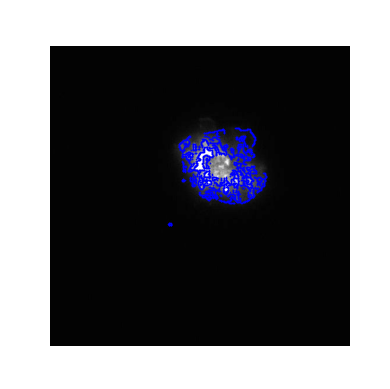

In [2]:
import matplotlib.pyplot as plt
from skimage import io, color, feature
frames = pims.open('mouse_actin1/*.jpg')


import cv2
first_frame = frames[100]
# Load the image

image = first_frame

# Convert the image to grayscale
gray_image = color.rgb2gray(image)

blurred_frame = cv2.GaussianBlur(first_frame, (5, 5),100)  # Applying Gaussian blur with kernel size (5, 5)
binary_img = np.where(blurred_frame > 20, 1,0)
center_of_mass = ndimage.measurements.center_of_mass(binary_img)
# Detect edges using Canny edge detection
edges = feature.canny(gray_image,low_threshold=10, high_threshold=40)
edge_coords = []
rows, cols = edges.shape
threshold = 20  # Radial distance threshold

for row in range(rows):
    for col in range(cols):
        if edges[row, col]:
            # Calculate the radial distance between the edge coordinate and the center
            radial_distance = np.sqrt((col - center_of_mass[1]) ** 2 + (row - center_of_mass[0]) ** 2)
            
            # Exclude points with radial distance less than the threshold
            if radial_distance >= threshold:
                edge_coords.append((col, row))  # Append (x, y) coordinates
# Plot the original image with the edges overlay`
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image)
#ax.imshow(edges, alpha=0.3)
ax.axis('off')

# Plot the edge coordinates as a scatter plot
edge_coords = np.array(edge_coords)
ax.scatter(edge_coords[:, 0], edge_coords[:, 1], color='blue', s=0.5)

plt.show()

In [3]:
@pims.pipeline
def gray(image):
    return image[:,:, 1]  # Take just the green channel
m_p=1
Fps=1
frames = pims.open('mouse_tcr1/*.jpg')

conect=4
mem=5
size=7
mass=100
filt=9
#tmMwt,dataMwt=find_traj_data(framesMwt,conect,mem,size,mass,filt)
#msd_Mwt,dt_Mwt=find_msd(tmMwt,40)
n=1
f = tp.locate(frames[n],size,minmass=mass)
tp.annotate(f, frames[n],plot_style={'markersize':10});
plt.imshow(frames[n])
ratio_list=[]
#rmin=40
#rmax=100
rmin=30
rmax=70
tm,data=find_traj_data(frames,conect,mem,size,mass,filt)
ee,xe,ye,iid=find_ee_distance2(data)
x_cm,y_cm=find_cm(frames,tm,size)

print(x_cm,y_cm)
c=4.5
plt.scatter(x_cm,y_cm,s=10,color='r')
print(x_cm,y_cm)
ri,rf,iidr=find_rad_distance2(data,x_cm,y_cm)
x,y,t=in_out2(c,ri,rf,xe,ye,ee,iidr,data,frames,rmin,rmax)
plt.imshow(frames[0])
plt.show()


frames = pims.open('mouse_actin1/*.jpg')
display= pims.open('mouse_tcr1/*.jpg')
error_threshold = 0.5
corelation=0
tot_coord=0
print(len(frames))
edge_store_x=[]
edge_store_y=[]
x_store=[]
y_store=[]
for f in range(200):
    
   
            
            
    # Plot the actin density from the current frame
    first_frame = frames[f]
    display_loop=display[f]
    ax.cla()
    frame_curr = first_frame/255
    ax.imshow(frame_curr,origin='lower',cmap="Greys_r",vmin=0,vmax=1)
    # Load the image

    image = first_frame

    # Convert the image to grayscale
    gray_image = color.rgb2gray(image)

    blurred_frame = cv2.GaussianBlur(first_frame, (5, 5),100)  # Applying Gaussian blur with kernel size (5, 5)
    binary_img = np.where(blurred_frame > threshold, 1,0)
    center_of_mass = ndimage.measurements.center_of_mass(binary_img)
    # Detect edges using Canny edge detection
    edges = edges = feature.canny(gray_image)
    edge_coords = []
    rows, cols = edges.shape
    threshold = 20  # Radial distance threshold

    for row in range(rows):
        for col in range(cols):
            if edges[row, col]:
                # Calculate the radial distance between the edge coordinate and the center
                radial_distance = np.sqrt((col - center_of_mass[1]) ** 2 + (row - center_of_mass[0]) ** 2)
            
                # Exclude points with radial distance less than the threshold
                if radial_distance >= threshold:
                    edge_coords.append((col, row))  # Append (x, y) coordinates
                    
    
    # Plot the original image with the edges overlay
    #fig, ax = plt.subplots(figsize=(8, 8))
    #ax.imshow(display_loop)
   # ax.imshow(edges, alpha=0.3) 
    ax.axis('off')

    # Plot the edge coordinates as a scatter plot
    edge_coords = np.array(edge_coords)
    ax.scatter(edge_coords[:, 0], edge_coords[:, 1], color='blue', s=0.5)
    for x_edge in edge_coords[:, 0]:
        edge_store_x.append(x_edge)
        
    for y_edge in edge_coords[:, 1]:
        edge_store_y.append(y_edge)
    for i,t_particle_i in enumerate(t):
        for j,ti in enumerate(t_particle_i):
            if ti==f:   ## check if particle frame is the same
              #  print(x[i][j],edge_coords[:, 0])
                x_store.append(x[i][j])
                y_store.append(y[i][j])
                tot_coord += 1
                #print(xi,edge_coords[:, 0])
                # Check if xi is within error_threshold of any value in edge_coords[:, 0]
                xi_within_range = any(abs(x[i][j] - edge_x) <= error_threshold for edge_x in edge_coords[:, 0])
                yi_within_range = any(abs(y[i][j] - edge_y) <= error_threshold for edge_y in edge_coords[:, 1])
                #print(xi_within_range)
                if xi_within_range==True and yi_within_range==True:
                    corelation += 1
    #print(corelation/tot_coord)             
   # ax.set_title("Frame no %03d"%f)
    #plt.savefig("wt_1/frame_%03d.png"%f,bbox_inches="tight")
print(corelation/tot_coord)

/home/samuel/anaconda3/lib/python3.9/site-packages/pims/api.py:204: UserWarning: <class 'pims.image_reader.ImageReader'> errored: No such file: '/home/samuel/Documents/actin dynamics wasp/mouse_tcr1/*.jpg'
  warn(message)
/home/samuel/anaconda3/lib/python3.9/site-packages/pims/api.py:204: UserWarning: <class 'pims.image_reader.ImageReaderND'> errored: No such file: '/home/samuel/Documents/actin dynamics wasp/mouse_tcr1/*.jpg'
  warn(message)
/home/samuel/anaconda3/lib/python3.9/site-packages/pims/api.py:204: UserWarning: <class 'pims.imageio_reader.ImageIOReader'> errored: No such file: '/home/samuel/Documents/actin dynamics wasp/mouse_tcr1/*.jpg'
  warn(message)
/home/samuel/anaconda3/lib/python3.9/site-packages/pims/api.py:204: UserWarning: <class 'pims.bioformats.BioformatsReader'> errored: The file "mouse_tcr1/*.jpg" does not exist.
  warn(message)


UnknownFormatError: All handlers returned exceptions:
<class 'pims.image_reader.ImageReader'> errored: No such file: '/home/samuel/Documents/actin dynamics wasp/mouse_tcr1/*.jpg'
<class 'pims.image_reader.ImageReaderND'> errored: No such file: '/home/samuel/Documents/actin dynamics wasp/mouse_tcr1/*.jpg'
<class 'pims.imageio_reader.ImageIOReader'> errored: No such file: '/home/samuel/Documents/actin dynamics wasp/mouse_tcr1/*.jpg'
<class 'pims.bioformats.BioformatsReader'> errored: The file "mouse_tcr1/*.jpg" does not exist.
